In [71]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
sys.path.append('..')
import json
import tqdm
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from libs.model import ECG_CNN
from libs.dataloader import ECGDataset
from libs.helper import calculate_eer_threshold, calculate_confusion_matrix
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [72]:
subject_id = 'c1s01'
split_type = 'cross_cgm' # 'cross_cgm' or 'cross_date' 
version = 'v1'
dataset_dir = '../dataset'

In [73]:
subject_data_path = os.path.join(dataset_dir, 'data', f'{subject_id}.pkl')
df = pd.read_pickle(subject_data_path)
metadata_path = os.path.join(dataset_dir, 'metadata', split_type, f'{subject_id}.json')

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

In [74]:
train_data = ECGDataset(df, metadata[version]['train'], verbose=True)
val_data = ECGDataset(df, metadata[version]['val'], verbose=False)
test_data = ECGDataset(df, metadata[version]['test'], verbose=False)

Dataset info:
 - ECG data: 450182 normal, 32623 hypo, ratio 13.80
 - CGM data: 1393 normal, 93 hypo, ratio 14.98


In [75]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [76]:
model = ECG_CNN(num_data=250, out_features=30, normal_hypo_ratio=train_data.normal_hypo_ratio)
model.load_state_dict(torch.load(f'../checkpoints/{split_type}/beat/{subject_id}/{version}.pth')['model_state_dict'])
model = model.eval()
model = model.to(device)

In [77]:
def evaluate(loader):
    preds = []
    labels = []
    with torch.no_grad():
        for i, data in enumerate(tqdm.tqdm(loader)):
            ecg_data, hypo_label, glucose, cgm_idx = data
            ecg_data = ecg_data.float().to(device)
            hypo_label = hypo_label.to(device)
            
            logits = model(ecg_data)
            logits = logits.cpu().numpy()
            hypo_label = hypo_label.cpu().numpy()

            preds += logits.tolist()
            labels += hypo_label.tolist()
    return np.array(preds), np.array(labels)


In [78]:
train_preds, train_labels = evaluate(train_loader)
val_preds, val_labels = evaluate(val_loader)
test_preds, test_labels = evaluate(test_loader)

100%|██████████| 3379/3379 [00:15<00:00, 215.86it/s]


In [79]:
results = {
    'type': [],
    'preds': [],
    'labels': []
}

results['type'] += ['train'] * len(train_preds)
results['preds'] += train_preds.tolist()
results['labels'] += train_labels.tolist()

results['type'] += ['val'] * len(val_preds)
results['preds'] += val_preds.tolist()
results['labels'] += val_labels.tolist()

results['type'] += ['test'] * len(test_preds)
results['preds'] += test_preds.tolist()
results['labels'] += test_labels.tolist()

results = pd.DataFrame(results)

In [80]:
print(results)

         type     preds  labels
0       train  0.067853       0
1       train  0.194035       0
2       train  0.088953       0
3       train  0.000022       0
4       train  0.067853       1
...       ...       ...     ...
693129   test  0.041160       0
693130   test  0.060597       0
693131   test  0.003611       0
693132   test  0.100907       0
693133   test  0.076154       0

[693134 rows x 3 columns]


Train AUC: 0.9048
Val AUC: 0.8209
Test AUC: 0.8348


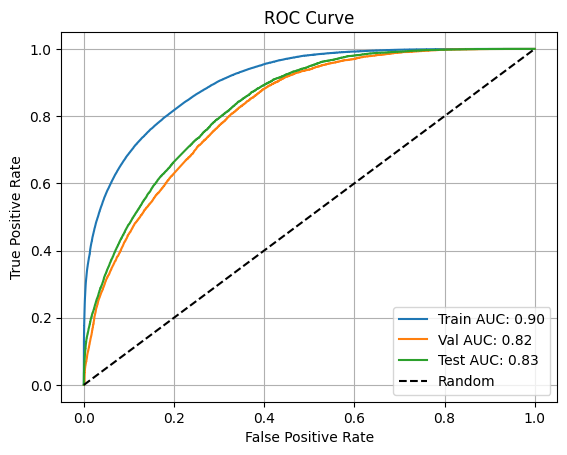

In [81]:
fig, ax = plt.subplots()

train_results = results[results['type'] == 'train']
for type in ['train', 'val', 'test']:
    result = results[results['type'] == type]
    fpr, tpr, _ = roc_curve(result['labels'], result['preds'])
    roc_auc = auc(fpr, tpr)
    print(f'{type.capitalize()} AUC: {roc_auc:.4f}')
    ax.plot(fpr, tpr, label=f'{type.capitalize()} AUC: {roc_auc:.2f}')

ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.grid()
plt.show()


EER Threshold: 0.0523


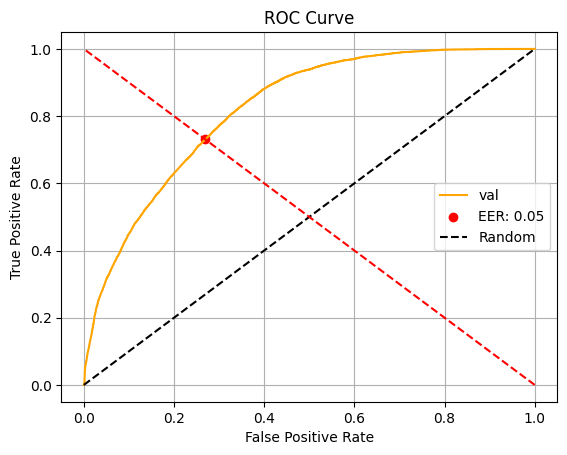

In [82]:
# find the eer threshold based on the validation set
val_results = results[results['type'] == 'val']
eer_threshold = calculate_eer_threshold(val_results['labels'], val_results['preds'])
print(f'EER Threshold: {eer_threshold:.4f}')

fpr, tpr, thresholds = roc_curve(val_results['labels'], val_results['preds'])
idx = np.abs(thresholds - eer_threshold).argmin()
plt.plot(fpr, tpr, label='val', color='orange')
plt.scatter(fpr[idx], tpr[idx], color='r', label=f'EER: {eer_threshold:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
plt.plot([1, 0], [0, 1], linestyle='--', color='r')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

In [83]:
# use the threshold to calculate the confusion matrix

train_results = results[results['type'] == 'train']
val_results = results[results['type'] == 'val']
test_results = results[results['type'] == 'test']

train_confusion_matrix, train_sensitivity, train_specificity = calculate_confusion_matrix(train_results['labels'], train_results['preds'], eer_threshold)
val_confusion_matrix, val_sensitivity, val_specificity = calculate_confusion_matrix(val_results['labels'], val_results['preds'], eer_threshold)
test_confusion_matrix, test_sensitivity, test_specificity = calculate_confusion_matrix(test_results['labels'], test_results['preds'], eer_threshold)

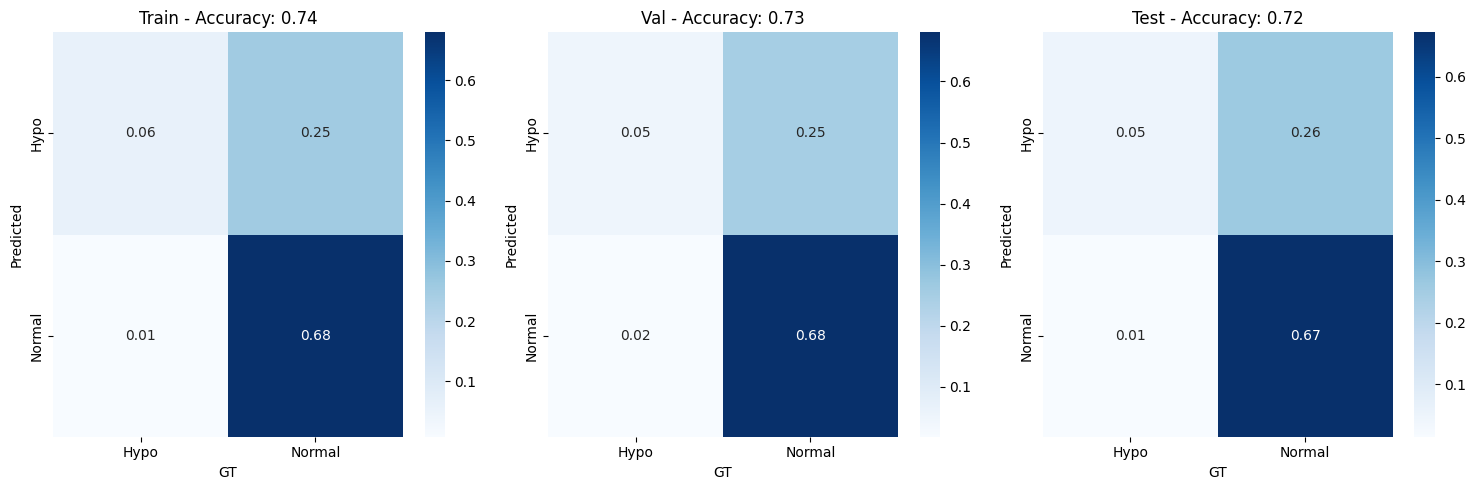

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(train_confusion_matrix, annot=True, fmt=".2f", cmap='Blues', ax=ax[0])
ax[0].set_xticklabels(['Hypo', 'Normal'])
ax[0].set_yticklabels(['Hypo', 'Normal'])
ax[0].set_xlabel('GT')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Train - Accuracy: {:.2f}'.format(train_confusion_matrix[0, 0] + train_confusion_matrix[1, 1]))

sns.heatmap(val_confusion_matrix, annot=True, fmt=".2f", cmap='Blues', ax=ax[1])
ax[1].set_xticklabels(['Hypo', 'Normal'])
ax[1].set_yticklabels(['Hypo', 'Normal'])
ax[1].set_xlabel('GT')
ax[1].set_ylabel('Predicted')
ax[1].set_title('Val - Accuracy: {:.2f}'.format(val_confusion_matrix[0, 0] + val_confusion_matrix[1, 1]))

sns.heatmap(test_confusion_matrix, annot=True, fmt=".2f", cmap='Blues', ax=ax[2])
ax[2].set_xticklabels(['Hypo', 'Normal'])
ax[2].set_yticklabels(['Hypo', 'Normal'])
ax[2].set_xlabel('GT')
ax[2].set_ylabel('Predicted')
ax[2].set_title('Test - Accuracy: {:.2f}'.format(test_confusion_matrix[0, 0] + test_confusion_matrix[1, 1]))

plt.tight_layout()
plt.show()
